# Practical work #2
## Was done by Kolabin Y.V.

In [33]:
import torchvision
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory
import os
import torch.nn as nn
from tqdm import tqdm
import copy
from torchsummary import summary

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation

train_data_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#### Define train and test datasets:

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    './datasets',
    train=True,
    transform=train_data_transform,
    download=True
    )

100%|██████████| 170498071/170498071 [00:05<00:00, 28550854.83it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


In [4]:
test_dataset = torchvision.datasets.CIFAR10(
    './datasets',
    train=False,
    transform=test_data_transform,
    download=True
    )

Files already downloaded and verified


#### CIFAR10 classes names retrieving:

In [5]:
class_names = train_dataset.classes

#### Device selection:

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### EDA:

In [7]:
general_samples_data = f"""
Number of classes: {len(train_dataset.classes)}
Names of classes: {class_names}
Shape of train dataset: {train_dataset.data.shape}
Shape of test dataset: {test_dataset.data.shape}
"""

print(general_samples_data)


Number of classes: 10
Names of classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Shape of train dataset: (50000, 32, 32, 3)
Shape of test dataset: (10000, 32, 32, 3)



#### Batch size definition:


In [8]:
batch_size = 128

#### Prepearing samples with DataLoaders:

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Some data samples visual representation:

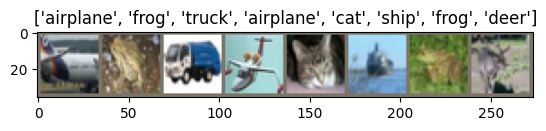

In [10]:
def imshow(inp, title=None):
    """Display image"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in classes[:8]])

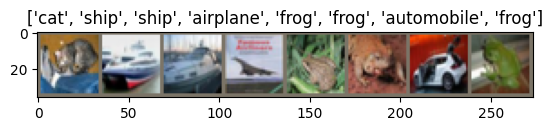

In [11]:
inputs, classes = next(iter(test_dataloader))

out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in classes[:8]])

In [12]:
# Calculate dataset sizes (it will help me in future)
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}

In [13]:
models_best_accuracy_pt = []
models_best_accuracy = []

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_acc = 0.0

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                if phase == 'train':
                  dataloader = train_dataloader
                else:
                  dataloader = test_dataloader

                for inputs, labels in tqdm(dataloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # if phase=='train' then enable gradients calculating
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, best_acc

In [15]:
models = [
    torchvision.models.get_model('GoogLeNet', weights=torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1),
    torchvision.models.get_model('resnet18', weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1),
    torchvision.models.get_model('shufflenet_v2_x0_5', weights=torchvision.models.ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1),
    torchvision.models.get_model('regnet_y_400mf', weights=torchvision.models.RegNet_Y_400MF_Weights.IMAGENET1K_V1)
    ]

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 153MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100%|██████████| 5.28M/5.28M [00:00<00:00, 56.1MB/s]
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-c65dace8.pth
100%|██████████| 16.8M/16.8M [00:00<00:00, 118MB/s]


In [16]:
for model in models:
    print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [17]:
for model in models:
  print('='*30)
  print(f"\tModel: {model.__class__.__name__}")
  print('='*30)

  model_ft = model

  print()

  # The number of input features for the last fully connected layer :
  num_ftrs = model_ft.fc.in_features

  model_ft.fc = nn.Linear(num_ftrs, 10)

  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

  model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=10)

  models_best_accuracy.append(best_acc.item())

	Model: GoogLeNet

Epoch 0/9
----------


100%|██████████| 391/391 [00:46<00:00,  8.46it/s]


train Loss: 1.0584 Acc: 0.6332


100%|██████████| 79/79 [00:03<00:00, 23.12it/s]


val Loss: 0.7310 Acc: 0.7487
Epoch 1/9
----------


100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


train Loss: 0.6420 Acc: 0.7809


100%|██████████| 79/79 [00:04<00:00, 18.85it/s]


val Loss: 0.6074 Acc: 0.7959
Epoch 2/9
----------


100%|██████████| 391/391 [00:31<00:00, 12.36it/s]


train Loss: 0.5158 Acc: 0.8233


100%|██████████| 79/79 [00:03<00:00, 24.26it/s]


val Loss: 0.5816 Acc: 0.8022
Epoch 3/9
----------


100%|██████████| 391/391 [00:30<00:00, 13.03it/s]


train Loss: 0.4321 Acc: 0.8520


100%|██████████| 79/79 [00:04<00:00, 18.12it/s]


val Loss: 0.5802 Acc: 0.8056
Epoch 4/9
----------


100%|██████████| 391/391 [00:30<00:00, 12.97it/s]


train Loss: 0.3663 Acc: 0.8748


100%|██████████| 79/79 [00:03<00:00, 24.58it/s]


val Loss: 0.5545 Acc: 0.8229
Epoch 5/9
----------


100%|██████████| 391/391 [00:30<00:00, 13.02it/s]


train Loss: 0.3221 Acc: 0.8901


100%|██████████| 79/79 [00:04<00:00, 18.58it/s]


val Loss: 0.5492 Acc: 0.8266
Epoch 6/9
----------


100%|██████████| 391/391 [00:29<00:00, 13.07it/s]


train Loss: 0.2178 Acc: 0.9269


100%|██████████| 79/79 [00:03<00:00, 24.50it/s]


val Loss: 0.5045 Acc: 0.8427
Epoch 7/9
----------


100%|██████████| 391/391 [00:29<00:00, 13.23it/s]


train Loss: 0.1819 Acc: 0.9394


100%|██████████| 79/79 [00:03<00:00, 21.08it/s]


val Loss: 0.5121 Acc: 0.8451
Epoch 8/9
----------


100%|██████████| 391/391 [00:30<00:00, 13.00it/s]


train Loss: 0.1631 Acc: 0.9449


100%|██████████| 79/79 [00:03<00:00, 24.63it/s]


val Loss: 0.5209 Acc: 0.8447
Epoch 9/9
----------


100%|██████████| 391/391 [00:37<00:00, 10.31it/s]


train Loss: 0.1499 Acc: 0.9503


100%|██████████| 79/79 [00:03<00:00, 24.32it/s]


val Loss: 0.5318 Acc: 0.8458
Training complete in 6m 3s
Best val Acc: 0.845800
	Model: ResNet

Epoch 0/9
----------


100%|██████████| 391/391 [00:25<00:00, 15.32it/s]


train Loss: 0.9073 Acc: 0.6903


100%|██████████| 79/79 [00:03<00:00, 26.20it/s]


val Loss: 0.6668 Acc: 0.7769
Epoch 1/9
----------


100%|██████████| 391/391 [00:25<00:00, 15.27it/s]


train Loss: 0.5712 Acc: 0.8054


100%|██████████| 79/79 [00:03<00:00, 26.05it/s]


val Loss: 0.5845 Acc: 0.8051
Epoch 2/9
----------


100%|██████████| 391/391 [00:26<00:00, 14.57it/s]


train Loss: 0.4581 Acc: 0.8448


100%|██████████| 79/79 [00:03<00:00, 25.93it/s]


val Loss: 0.5475 Acc: 0.8150
Epoch 3/9
----------


100%|██████████| 391/391 [00:25<00:00, 15.38it/s]


train Loss: 0.3890 Acc: 0.8659


100%|██████████| 79/79 [00:03<00:00, 23.24it/s]


val Loss: 0.5438 Acc: 0.8167
Epoch 4/9
----------


100%|██████████| 391/391 [00:24<00:00, 15.72it/s]


train Loss: 0.3350 Acc: 0.8846


100%|██████████| 79/79 [00:03<00:00, 20.87it/s]


val Loss: 0.5287 Acc: 0.8259
Epoch 5/9
----------


100%|██████████| 391/391 [00:24<00:00, 16.05it/s]


train Loss: 0.2957 Acc: 0.8988


100%|██████████| 79/79 [00:04<00:00, 19.61it/s]


val Loss: 0.5222 Acc: 0.8316
Epoch 6/9
----------


100%|██████████| 391/391 [00:24<00:00, 15.99it/s]


train Loss: 0.1873 Acc: 0.9371


100%|██████████| 79/79 [00:03<00:00, 20.82it/s]


val Loss: 0.4722 Acc: 0.8534
Epoch 7/9
----------


100%|██████████| 391/391 [00:24<00:00, 15.88it/s]


train Loss: 0.1419 Acc: 0.9531


100%|██████████| 79/79 [00:03<00:00, 22.59it/s]


val Loss: 0.4824 Acc: 0.8596
Epoch 8/9
----------


100%|██████████| 391/391 [00:24<00:00, 15.65it/s]


train Loss: 0.1243 Acc: 0.9590


100%|██████████| 79/79 [00:03<00:00, 25.85it/s]


val Loss: 0.5008 Acc: 0.8576
Epoch 9/9
----------


100%|██████████| 391/391 [00:25<00:00, 15.38it/s]


train Loss: 0.1112 Acc: 0.9631


100%|██████████| 79/79 [00:03<00:00, 25.49it/s]


val Loss: 0.5196 Acc: 0.8583
Training complete in 4m 47s
Best val Acc: 0.859600
	Model: ShuffleNetV2

Epoch 0/9
----------


100%|██████████| 391/391 [00:25<00:00, 15.38it/s]


train Loss: 1.8713 Acc: 0.3982


100%|██████████| 79/79 [00:03<00:00, 25.92it/s]


val Loss: 1.3273 Acc: 0.5492
Epoch 1/9
----------


100%|██████████| 391/391 [00:25<00:00, 15.28it/s]


train Loss: 1.1654 Acc: 0.5922


100%|██████████| 79/79 [00:03<00:00, 26.00it/s]


val Loss: 1.0419 Acc: 0.6259
Epoch 2/9
----------


100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


train Loss: 1.0023 Acc: 0.6475


100%|██████████| 79/79 [00:03<00:00, 24.99it/s]


val Loss: 0.9630 Acc: 0.6583
Epoch 3/9
----------


100%|██████████| 391/391 [00:25<00:00, 15.44it/s]


train Loss: 0.9242 Acc: 0.6731


100%|██████████| 79/79 [00:03<00:00, 25.63it/s]


val Loss: 0.9177 Acc: 0.6767
Epoch 4/9
----------


100%|██████████| 391/391 [00:24<00:00, 15.65it/s]


train Loss: 0.8700 Acc: 0.6934


100%|██████████| 79/79 [00:03<00:00, 24.46it/s]


val Loss: 0.8800 Acc: 0.6890
Epoch 5/9
----------


100%|██████████| 391/391 [00:24<00:00, 15.74it/s]


train Loss: 0.8308 Acc: 0.7067


100%|██████████| 79/79 [00:03<00:00, 20.78it/s]


val Loss: 0.8609 Acc: 0.6945
Epoch 6/9
----------


100%|██████████| 391/391 [00:24<00:00, 15.94it/s]


train Loss: 0.7713 Acc: 0.7282


100%|██████████| 79/79 [00:04<00:00, 19.00it/s]


val Loss: 0.8274 Acc: 0.7080
Epoch 7/9
----------


100%|██████████| 391/391 [00:24<00:00, 16.14it/s]


train Loss: 0.7537 Acc: 0.7351


100%|██████████| 79/79 [00:03<00:00, 19.94it/s]


val Loss: 0.8200 Acc: 0.7118
Epoch 8/9
----------


100%|██████████| 391/391 [00:24<00:00, 15.77it/s]


train Loss: 0.7506 Acc: 0.7367


100%|██████████| 79/79 [00:03<00:00, 22.78it/s]


val Loss: 0.8191 Acc: 0.7104
Epoch 9/9
----------


100%|██████████| 391/391 [00:24<00:00, 15.69it/s]


train Loss: 0.7397 Acc: 0.7402


100%|██████████| 79/79 [00:02<00:00, 26.68it/s]


val Loss: 0.8163 Acc: 0.7126
Training complete in 4m 44s
Best val Acc: 0.712600
	Model: RegNet

Epoch 0/9
----------


100%|██████████| 391/391 [00:34<00:00, 11.40it/s]


train Loss: 1.2156 Acc: 0.5852


100%|██████████| 79/79 [00:05<00:00, 15.62it/s]


val Loss: 0.8310 Acc: 0.7158
Epoch 1/9
----------


100%|██████████| 391/391 [00:33<00:00, 11.51it/s]


train Loss: 0.6938 Acc: 0.7611


100%|██████████| 79/79 [00:05<00:00, 15.01it/s]


val Loss: 0.6502 Acc: 0.7769
Epoch 2/9
----------


100%|██████████| 391/391 [00:33<00:00, 11.53it/s]


train Loss: 0.5602 Acc: 0.8037


100%|██████████| 79/79 [00:05<00:00, 15.62it/s]


val Loss: 0.6037 Acc: 0.7982
Epoch 3/9
----------


100%|██████████| 391/391 [00:34<00:00, 11.36it/s]


train Loss: 0.4766 Acc: 0.8335


100%|██████████| 79/79 [00:04<00:00, 17.29it/s]


val Loss: 0.5608 Acc: 0.8079
Epoch 4/9
----------


100%|██████████| 391/391 [00:34<00:00, 11.31it/s]


train Loss: 0.4158 Acc: 0.8556


100%|██████████| 79/79 [00:04<00:00, 18.77it/s]


val Loss: 0.5443 Acc: 0.8126
Epoch 5/9
----------


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


train Loss: 0.3709 Acc: 0.8703


100%|██████████| 79/79 [00:04<00:00, 18.47it/s]


val Loss: 0.5468 Acc: 0.8205
Epoch 6/9
----------


100%|██████████| 391/391 [00:35<00:00, 11.15it/s]


train Loss: 0.2761 Acc: 0.9056


100%|██████████| 79/79 [00:04<00:00, 19.24it/s]


val Loss: 0.5100 Acc: 0.8321
Epoch 7/9
----------


100%|██████████| 391/391 [00:35<00:00, 11.09it/s]


train Loss: 0.2442 Acc: 0.9171


100%|██████████| 79/79 [00:04<00:00, 19.22it/s]


val Loss: 0.5146 Acc: 0.8321
Epoch 8/9
----------


100%|██████████| 391/391 [00:35<00:00, 11.16it/s]


train Loss: 0.2240 Acc: 0.9243


100%|██████████| 79/79 [00:04<00:00, 18.22it/s]


val Loss: 0.5196 Acc: 0.8343
Epoch 9/9
----------


100%|██████████| 391/391 [00:35<00:00, 11.15it/s]


train Loss: 0.2124 Acc: 0.9280


100%|██████████| 79/79 [00:04<00:00, 17.39it/s]


val Loss: 0.5276 Acc: 0.8342
Training complete in 6m 33s
Best val Acc: 0.834300


In [18]:
models_best_accuracy

[0.8458, 0.8596, 0.7126, 0.8343]

#### Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [19]:
models2 = [
    torchvision.models.get_model('GoogLeNet', weights=torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1),
    torchvision.models.get_model('resnet18', weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1),
    torchvision.models.get_model('shufflenet_v2_x0_5', weights=torchvision.models.ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1),
    torchvision.models.get_model('regnet_y_400mf', weights=torchvision.models.RegNet_Y_400MF_Weights.IMAGENET1K_V1)
    ]

In [20]:
for model in models2:
  print('='*30)
  print(f"\tModel: {model.__class__.__name__}")
  print('='*30)

  model_pt = model

  for param in model_pt.parameters():
    param.requires_grad = False

  # The number of input features for the last fully connected layer :
  num_ftrs = model_pt.fc.in_features

  model_pt.fc = nn.Linear(num_ftrs, 10)

  model_pt = model_pt.to(device)

  criterion = nn.CrossEntropyLoss()

  optimizer_pt = optim.SGD(model_pt.parameters(), lr=0.01, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_pt, step_size=6, gamma=0.1)

  model_pt, best_acc = train_model(model_pt, criterion, optimizer_pt, exp_lr_scheduler,
                        num_epochs=10)
  models_best_accuracy_pt.append(best_acc.item())

	Model: GoogLeNet
Epoch 0/9
----------


100%|██████████| 391/391 [00:20<00:00, 18.70it/s]


train Loss: 1.8945 Acc: 0.3331


100%|██████████| 79/79 [00:03<00:00, 20.80it/s]


val Loss: 1.7599 Acc: 0.3888
Epoch 1/9
----------


100%|██████████| 391/391 [00:20<00:00, 19.14it/s]


train Loss: 1.8030 Acc: 0.3699


100%|██████████| 79/79 [00:04<00:00, 19.03it/s]


val Loss: 1.7443 Acc: 0.3954
Epoch 2/9
----------


100%|██████████| 391/391 [00:20<00:00, 19.34it/s]


train Loss: 1.7962 Acc: 0.3698


100%|██████████| 79/79 [00:03<00:00, 23.45it/s]


val Loss: 1.7428 Acc: 0.3959
Epoch 3/9
----------


100%|██████████| 391/391 [00:21<00:00, 18.49it/s]


train Loss: 1.7905 Acc: 0.3781


100%|██████████| 79/79 [00:03<00:00, 23.03it/s]


val Loss: 1.7391 Acc: 0.4011
Epoch 4/9
----------


100%|██████████| 391/391 [00:21<00:00, 18.61it/s]


train Loss: 1.7906 Acc: 0.3762


100%|██████████| 79/79 [00:03<00:00, 23.77it/s]


val Loss: 1.7262 Acc: 0.4026
Epoch 5/9
----------


100%|██████████| 391/391 [00:20<00:00, 19.27it/s]


train Loss: 1.7962 Acc: 0.3728


100%|██████████| 79/79 [00:04<00:00, 19.55it/s]


val Loss: 1.7342 Acc: 0.3985
Epoch 6/9
----------


100%|██████████| 391/391 [00:19<00:00, 19.90it/s]


train Loss: 1.7545 Acc: 0.3883


100%|██████████| 79/79 [00:03<00:00, 22.11it/s]


val Loss: 1.7045 Acc: 0.4115
Epoch 7/9
----------


100%|██████████| 391/391 [00:20<00:00, 19.00it/s]


train Loss: 1.7435 Acc: 0.3921


100%|██████████| 79/79 [00:03<00:00, 23.75it/s]


val Loss: 1.6970 Acc: 0.4146
Epoch 8/9
----------


100%|██████████| 391/391 [00:20<00:00, 18.85it/s]


train Loss: 1.7418 Acc: 0.3929


100%|██████████| 79/79 [00:03<00:00, 23.34it/s]


val Loss: 1.6891 Acc: 0.4161
Epoch 9/9
----------


100%|██████████| 391/391 [00:20<00:00, 19.30it/s]


train Loss: 1.7352 Acc: 0.3943


100%|██████████| 79/79 [00:03<00:00, 20.13it/s]


val Loss: 1.6886 Acc: 0.4146
Training complete in 4m 2s
Best val Acc: 0.416100
	Model: ResNet
Epoch 0/9
----------


100%|██████████| 391/391 [00:18<00:00, 21.16it/s]


train Loss: 1.7605 Acc: 0.3977


100%|██████████| 79/79 [00:03<00:00, 24.90it/s]


val Loss: 1.6675 Acc: 0.4193
Epoch 1/9
----------


100%|██████████| 391/391 [00:19<00:00, 20.14it/s]


train Loss: 1.6874 Acc: 0.4266


100%|██████████| 79/79 [00:03<00:00, 24.81it/s]


val Loss: 1.6369 Acc: 0.4418
Epoch 2/9
----------


100%|██████████| 391/391 [00:18<00:00, 21.21it/s]


train Loss: 1.6883 Acc: 0.4287


100%|██████████| 79/79 [00:04<00:00, 19.09it/s]


val Loss: 1.6909 Acc: 0.4274
Epoch 3/9
----------


100%|██████████| 391/391 [00:18<00:00, 21.46it/s]


train Loss: 1.6893 Acc: 0.4318


100%|██████████| 79/79 [00:03<00:00, 25.01it/s]


val Loss: 1.7448 Acc: 0.4165
Epoch 4/9
----------


100%|██████████| 391/391 [00:19<00:00, 20.03it/s]


train Loss: 1.6803 Acc: 0.4313


100%|██████████| 79/79 [00:03<00:00, 24.76it/s]


val Loss: 1.7044 Acc: 0.4280
Epoch 5/9
----------


100%|██████████| 391/391 [00:18<00:00, 21.48it/s]


train Loss: 1.6647 Acc: 0.4338


100%|██████████| 79/79 [00:03<00:00, 21.89it/s]


val Loss: 1.6715 Acc: 0.4386
Epoch 6/9
----------


100%|██████████| 391/391 [00:18<00:00, 20.70it/s]


train Loss: 1.5437 Acc: 0.4660


100%|██████████| 79/79 [00:03<00:00, 24.94it/s]


val Loss: 1.5520 Acc: 0.4703
Epoch 7/9
----------


100%|██████████| 391/391 [00:18<00:00, 20.68it/s]


train Loss: 1.5152 Acc: 0.4762


100%|██████████| 79/79 [00:03<00:00, 21.42it/s]


val Loss: 1.5518 Acc: 0.4676
Epoch 8/9
----------


100%|██████████| 391/391 [00:18<00:00, 21.46it/s]


train Loss: 1.5049 Acc: 0.4783


100%|██████████| 79/79 [00:03<00:00, 24.88it/s]


val Loss: 1.5443 Acc: 0.4712
Epoch 9/9
----------


100%|██████████| 391/391 [00:19<00:00, 20.15it/s]


train Loss: 1.5071 Acc: 0.4792


100%|██████████| 79/79 [00:03<00:00, 24.48it/s]


val Loss: 1.5413 Acc: 0.4749
Training complete in 3m 42s
Best val Acc: 0.474900
	Model: ShuffleNetV2
Epoch 0/9
----------


100%|██████████| 391/391 [00:19<00:00, 19.89it/s]


train Loss: 2.1631 Acc: 0.3442


100%|██████████| 79/79 [00:03<00:00, 20.65it/s]


val Loss: 2.0525 Acc: 0.4035
Epoch 1/9
----------


100%|██████████| 391/391 [00:19<00:00, 20.20it/s]


train Loss: 1.9719 Acc: 0.4083


100%|██████████| 79/79 [00:03<00:00, 25.98it/s]


val Loss: 1.9181 Acc: 0.4112
Epoch 2/9
----------


100%|██████████| 391/391 [00:20<00:00, 19.06it/s]


train Loss: 1.8664 Acc: 0.4143


100%|██████████| 79/79 [00:03<00:00, 25.03it/s]


val Loss: 1.8412 Acc: 0.4206
Epoch 3/9
----------


100%|██████████| 391/391 [00:20<00:00, 18.93it/s]


train Loss: 1.7997 Acc: 0.4275


100%|██████████| 79/79 [00:03<00:00, 24.39it/s]


val Loss: 1.7811 Acc: 0.4306
Epoch 4/9
----------


100%|██████████| 391/391 [00:19<00:00, 19.95it/s]


train Loss: 1.7553 Acc: 0.4336


100%|██████████| 79/79 [00:03<00:00, 20.39it/s]


val Loss: 1.7404 Acc: 0.4366
Epoch 5/9
----------


100%|██████████| 391/391 [00:19<00:00, 19.83it/s]


train Loss: 1.7194 Acc: 0.4375


100%|██████████| 79/79 [00:03<00:00, 26.20it/s]


val Loss: 1.7148 Acc: 0.4408
Epoch 6/9
----------


100%|██████████| 391/391 [00:20<00:00, 19.01it/s]


train Loss: 1.7035 Acc: 0.4452


100%|██████████| 79/79 [00:03<00:00, 25.41it/s]


val Loss: 1.7058 Acc: 0.4427
Epoch 7/9
----------


100%|██████████| 391/391 [00:19<00:00, 19.97it/s]


train Loss: 1.7009 Acc: 0.4450


100%|██████████| 79/79 [00:03<00:00, 19.85it/s]


val Loss: 1.7114 Acc: 0.4406
Epoch 8/9
----------


100%|██████████| 391/391 [00:19<00:00, 20.11it/s]


train Loss: 1.6952 Acc: 0.4459


100%|██████████| 79/79 [00:03<00:00, 25.82it/s]


val Loss: 1.6994 Acc: 0.4435
Epoch 9/9
----------


100%|██████████| 391/391 [00:20<00:00, 18.87it/s]


train Loss: 1.6944 Acc: 0.4480


100%|██████████| 79/79 [00:03<00:00, 25.74it/s]


val Loss: 1.7014 Acc: 0.4450
Training complete in 3m 54s
Best val Acc: 0.445000
	Model: RegNet
Epoch 0/9
----------


100%|██████████| 391/391 [00:28<00:00, 13.91it/s]


train Loss: 1.8287 Acc: 0.3748


100%|██████████| 79/79 [00:05<00:00, 15.43it/s]


val Loss: 1.7437 Acc: 0.4064
Epoch 1/9
----------


100%|██████████| 391/391 [00:29<00:00, 13.46it/s]


train Loss: 1.7786 Acc: 0.3948


100%|██████████| 79/79 [00:04<00:00, 17.07it/s]


val Loss: 1.7728 Acc: 0.4056
Epoch 2/9
----------


100%|██████████| 391/391 [00:28<00:00, 13.74it/s]


train Loss: 1.7622 Acc: 0.4017


100%|██████████| 79/79 [00:04<00:00, 16.68it/s]


val Loss: 1.7593 Acc: 0.3976
Epoch 3/9
----------


100%|██████████| 391/391 [00:28<00:00, 13.52it/s]


train Loss: 1.7800 Acc: 0.3983


100%|██████████| 79/79 [00:05<00:00, 15.64it/s]


val Loss: 1.7379 Acc: 0.4108
Epoch 4/9
----------


100%|██████████| 391/391 [00:28<00:00, 13.72it/s]


train Loss: 1.7730 Acc: 0.3987


100%|██████████| 79/79 [00:04<00:00, 17.32it/s]


val Loss: 1.7045 Acc: 0.4139
Epoch 5/9
----------


100%|██████████| 391/391 [00:28<00:00, 13.72it/s]


train Loss: 1.7749 Acc: 0.3990


100%|██████████| 79/79 [00:05<00:00, 13.66it/s]


val Loss: 1.8291 Acc: 0.3974
Epoch 6/9
----------


100%|██████████| 391/391 [00:28<00:00, 13.76it/s]


train Loss: 1.6144 Acc: 0.4359


100%|██████████| 79/79 [00:04<00:00, 16.81it/s]


val Loss: 1.5836 Acc: 0.4444
Epoch 7/9
----------


100%|██████████| 391/391 [00:28<00:00, 13.76it/s]


train Loss: 1.5614 Acc: 0.4524


100%|██████████| 79/79 [00:05<00:00, 14.10it/s]


val Loss: 1.5692 Acc: 0.4496
Epoch 8/9
----------


100%|██████████| 391/391 [00:28<00:00, 13.69it/s]


train Loss: 1.5545 Acc: 0.4533


100%|██████████| 79/79 [00:04<00:00, 17.20it/s]


val Loss: 1.5597 Acc: 0.4508
Epoch 9/9
----------


100%|██████████| 391/391 [00:28<00:00, 13.65it/s]


train Loss: 1.5470 Acc: 0.4529


100%|██████████| 79/79 [00:05<00:00, 15.29it/s]


val Loss: 1.5579 Acc: 0.4516
Training complete in 5m 36s
Best val Acc: 0.451600


In [21]:
models_best_accuracy_pt

[0.4161, 0.47490000000000004, 0.445, 0.4516]

In [40]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()

        # Convolution. The size of the resulting feature map:
        # 32 x ((32 - 3 + 2*1)/1 + 1) x ((32 - 3 + 2*1)/1 + 1)
        # 32 x 32 x 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Batch normalization:
        self.bn1 = nn.BatchNorm2d(32)

        # Activation function. The size of the resulting feature map:
        # 32 x 32 x 32
        self.relu = nn.ReLU()

        # Spatial max pooling. The size of the resulting feature map:
        # 32 x ((32 - 3)/2 + 1) x ((32 - 3)/2 + 1)
        # 32 x 15 x 15
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution. The size of the resulting feature map:
        # 64 x ((15 - 3 + 2*1)/1 + 1) x ((15 - 3 + 2*1)/1 + 1)
        # 64 x 16 x 16
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Batch normalization:
        self.bn2 = nn.BatchNorm2d(64)

        # Activation function. The size of the resulting feature map:
        # 64 x 16 x 16

        # Spatial max pooling. The size of the resulting feature map:
        # 64 x ((15 - 3)/2 + 1) x ((15 - 3)/2 + 1)
        # 64 x 8 x 8

        # Fully connected layer:
        self.fc1 = nn.Linear(64 * 8 * 8, 128)

        # Dropout:
        self.dropout = nn.Dropout(0.5)

        # Output fully connected layer:
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

cnn_model = ConvolutionalNeuralNetwork()

In [41]:
learning_rate = 0.03
num_epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr = learning_rate)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

In [42]:
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 128]         524,416
             ReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 545,290
Trainable params: 545,290
Non-trainable params: 0
-------------------------------

In [43]:
_, my_best_accuracy = train_model(cnn_model, loss_function, optimizer, exp_lr_scheduler, num_epochs)

Epoch 0/19
----------


100%|██████████| 391/391 [00:19<00:00, 20.21it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.5939 Acc: 0.4192


100%|██████████| 79/79 [00:02<00:00, 31.19it/s]


val Loss: 1.2799 Acc: 0.5415
Epoch 1/19
----------


100%|██████████| 391/391 [00:21<00:00, 18.46it/s]


train Loss: 1.2872 Acc: 0.5381


100%|██████████| 79/79 [00:02<00:00, 29.90it/s]


val Loss: 1.0911 Acc: 0.6190
Epoch 2/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.59it/s]


train Loss: 1.1631 Acc: 0.5889


100%|██████████| 79/79 [00:02<00:00, 31.66it/s]


val Loss: 1.0855 Acc: 0.6119
Epoch 3/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.20it/s]


train Loss: 1.0829 Acc: 0.6179


100%|██████████| 79/79 [00:02<00:00, 26.52it/s]


val Loss: 0.9631 Acc: 0.6583
Epoch 4/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.75it/s]


train Loss: 1.0240 Acc: 0.6399


100%|██████████| 79/79 [00:02<00:00, 31.18it/s]


val Loss: 0.9216 Acc: 0.6802
Epoch 5/19
----------


100%|██████████| 391/391 [00:17<00:00, 21.97it/s]


train Loss: 0.9812 Acc: 0.6526


100%|██████████| 79/79 [00:03<00:00, 23.06it/s]


val Loss: 0.9142 Acc: 0.6697
Epoch 6/19
----------


100%|██████████| 391/391 [00:17<00:00, 21.89it/s]


train Loss: 0.9410 Acc: 0.6702


100%|██████████| 79/79 [00:02<00:00, 31.66it/s]


val Loss: 0.9417 Acc: 0.6709
Epoch 7/19
----------


100%|██████████| 391/391 [00:17<00:00, 21.83it/s]


train Loss: 0.9118 Acc: 0.6802


100%|██████████| 79/79 [00:03<00:00, 23.61it/s]


val Loss: 0.8944 Acc: 0.6886
Epoch 8/19
----------


100%|██████████| 391/391 [00:18<00:00, 21.63it/s]


train Loss: 0.8803 Acc: 0.6911


100%|██████████| 79/79 [00:02<00:00, 29.87it/s]


val Loss: 0.8287 Acc: 0.7108
Epoch 9/19
----------


100%|██████████| 391/391 [00:18<00:00, 21.55it/s]


train Loss: 0.8577 Acc: 0.6996


100%|██████████| 79/79 [00:03<00:00, 24.69it/s]


val Loss: 0.8113 Acc: 0.7171
Epoch 10/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.44it/s]


train Loss: 0.8342 Acc: 0.7078


100%|██████████| 79/79 [00:02<00:00, 31.37it/s]


val Loss: 0.8046 Acc: 0.7168
Epoch 11/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.15it/s]


train Loss: 0.8113 Acc: 0.7163


100%|██████████| 79/79 [00:03<00:00, 22.37it/s]


val Loss: 0.8351 Acc: 0.7048
Epoch 12/19
----------


100%|██████████| 391/391 [00:17<00:00, 21.86it/s]


train Loss: 0.7961 Acc: 0.7208


100%|██████████| 79/79 [00:02<00:00, 31.21it/s]


val Loss: 0.9119 Acc: 0.6882
Epoch 13/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.11it/s]


train Loss: 0.7794 Acc: 0.7269


100%|██████████| 79/79 [00:03<00:00, 22.85it/s]


val Loss: 0.7413 Acc: 0.7368
Epoch 14/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.31it/s]


train Loss: 0.7565 Acc: 0.7358


100%|██████████| 79/79 [00:02<00:00, 30.38it/s]


val Loss: 0.7554 Acc: 0.7353
Epoch 15/19
----------


100%|██████████| 391/391 [00:18<00:00, 20.81it/s]


train Loss: 0.7412 Acc: 0.7401


100%|██████████| 79/79 [00:03<00:00, 23.86it/s]


val Loss: 0.7247 Acc: 0.7468
Epoch 16/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.07it/s]


train Loss: 0.7249 Acc: 0.7459


100%|██████████| 79/79 [00:02<00:00, 30.13it/s]


val Loss: 0.7464 Acc: 0.7372
Epoch 17/19
----------


100%|██████████| 391/391 [00:17<00:00, 21.77it/s]


train Loss: 0.7107 Acc: 0.7501


100%|██████████| 79/79 [00:03<00:00, 23.47it/s]


val Loss: 0.7355 Acc: 0.7422
Epoch 18/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.45it/s]


train Loss: 0.6973 Acc: 0.7539


100%|██████████| 79/79 [00:02<00:00, 31.25it/s]


val Loss: 0.7250 Acc: 0.7509
Epoch 19/19
----------


100%|██████████| 391/391 [00:17<00:00, 22.39it/s]


train Loss: 0.6849 Acc: 0.7583


100%|██████████| 79/79 [00:03<00:00, 21.85it/s]

val Loss: 0.7776 Acc: 0.7286
Training complete in 6m 59s
Best val Acc: 0.750900


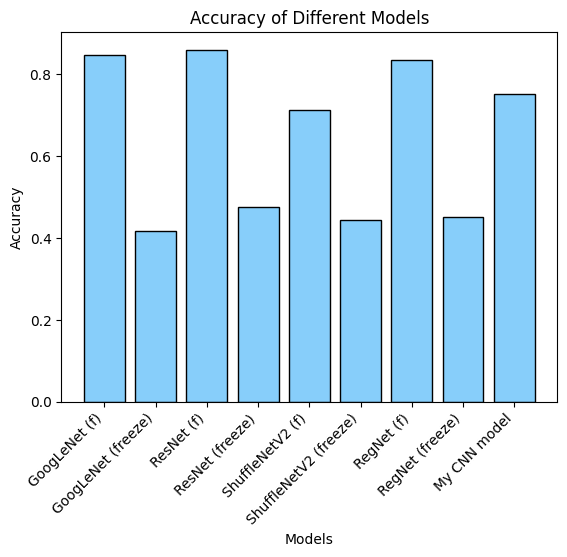

In [44]:
import matplotlib.pyplot as plt

models = ['GoogLeNet (f)', 'GoogLeNet (freeze)', 'ResNet (f)', 'ResNet (freeze)', 'ShuffleNetV2 (f)', 'ShuffleNetV2 (freeze)', 'RegNet (f)', 'RegNet (freeze)', 'My CNN model']
accuracy = [models_best_accuracy[0], models_best_accuracy_pt[0], models_best_accuracy[1], models_best_accuracy_pt[1],
            models_best_accuracy[2], models_best_accuracy_pt[2], models_best_accuracy[3], models_best_accuracy_pt[3],
            my_best_accuracy.item()]

# Specify a pastel color (e.g., pastel blue)
pastel_blue = '#87CEFA'

# Add a stroke to the bars using edgecolor
plt.bar(models, accuracy, color=pastel_blue, edgecolor='black')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.show()

